In [20]:
# Run this cell only if working in Colab
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
if os.path.exists('./sample_data'):
  !rm -r ./sample_data

repo_name = "ASL-ClassAndDetect" # Enter repo name

if not os.path.isdir('./' + repo_name):
  # Clone GitHub files to colab workspace
  git_path = 'https://github.com/christianwhollar/ASL-ClassAndDetect.git'
  !git clone "{git_path}"

# Change working directory to location of notebook
if not os.path.basename(os.getcwd()) == repo_name:
  %cd "{repo_name}"
  
  # Install dependencies from requirements.txt file
  !pip install -r requirements.txt

In [29]:
from google.colab import files

if 'kaggle.json' not in os.listdir():
  files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json

In [1]:
%run setup

/Users/christianhollar/Desktop/540/ASL-ClassAndDetect/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/christianhollar/Desktop/540/ASL-ClassAndDetect/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


144
31
New Model Import

--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

* PROGRESS IN EPOCH 1 :   0%|          | 0/144 [00:00<?, ?it/s]HERE
torch.Size([512, 36])
torch.Size([512])
* PROGRESS IN EPOCH 1 :   0%|          | 0/144 [00:27<?, ?it/s]


IndexError: Target 38 is out of bounds.

In [21]:
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

#contents = pickle.load(f) becomes...
filename = os.getcwd() + '/models/mobilenetv2_asl.pkl'
model = CPU_Unpickler(open(filename, 'rb')).load()

In [23]:
import numpy as np
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [ ]:
### try your model on some images
%matplotlib inline


#turn model to evaluation mode
model.eval()
valid_path = './data/app/'

#load some of the test data 
# test_data = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
# testloader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True)
# images , labels=next( iter(testloader) )

In [28]:
from scripts.build_features import *

bf = BuildFeatures(
        batch_size = 512,
        train_path = './data/processed/asl_alphabet_train',
        valid_path = './data/processed/asl_alphabet_valid',
        test_path = './data/processed/asl_alphabet_valid' 
    )
    
bf.build_transformers()
train_data, test_data = bf.build_data()
trainloader, testloader = bf.build_dataloaders()

image number 77
---------------------
label: Z
prediction: Z


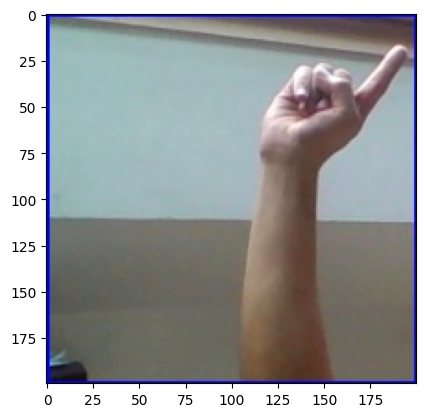

In [29]:
#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0)#.cuda()

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])



In [32]:
from PIL import Image

In [49]:
img = Image.open(os.getcwd() + '/data/app/A_test.jpg')
valid_path = './data/processed/asl_alphabet_1/asl_alphabet_valid'
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)
test_data = datasets.ImageFolder(valid_path, transform = test_transforms)


img_normalized = test_transforms(img).float()
img_normalized = img_normalized.unsqueeze_(0)

In [50]:
with torch.no_grad():
    model.eval()  
    output =model(img_normalized)
    # print(output)
    index = output.data.cpu().numpy().argmax()
    class_name = classes[index]
print(class_name)

A


In [42]:
import torch.nn.functional as F

In [43]:
test_loader

NameError: name 'test_loader' is not defined

In [55]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels.cpu())
            print('DATA COMPLETE')
        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(10):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals

In [56]:
# Test the pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc,recall_vals = test_model(model,testloader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(10):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))



DATA COMPLETE
DATA COMPLETE


KeyboardInterrupt: 

In [58]:
testloader

In [59]:
print(len(testloader))


29
